## Initialize the Env

In [1]:

import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Dict
import wandb

from brax import envs
from brax.envs.base import PipelineEnv, State
from brax.training.agents.ppo import train as ppo
from brax.io import model
from brax.io import mjcf as mjcf_brax

from dm_control import mjcf as mjcf_dm

import mujoco
from mujoco import mjx
import os

import yaml
from typing import Dict, Text

from Rodent_Env_Brax import Rodent


In [2]:
!nvidia-smi

Tue Mar 26 12:28:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000000:3D:00.0 Off |                    0 |
| N/A   35C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/n/home05/charleszhang/.conda/envs/stac-mjx/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=3330860) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


## Load the Checkpoint


*Notes*: Really understand the train.ppo and the brax.acting, to see how we can manage to load the checkpoint and generate another eval from the checkpoint

In [3]:
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_async_collectives=true '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
)
n_gpus = jax.device_count(backend="gpu")
print(f"Using {n_gpus} GPUs")

config = {
    "env_name": "rodent",
    "algo_name": "ppo",
    "task_name": "run",
    "num_envs": 4096*n_gpus,
    "num_timesteps": 500_000_000,
    "eval_every": 1_000_000,
    "episode_length": 1000,
    "batch_size": 4096*n_gpus,
    "learning_rate": 5e-5,
    "terminate_when_unhealthy": True,
    "run_platform": "Harvard",
    "solver": "cg",
    "iterations": 4,
    "ls_iterations": 4,
}

envs.register_environment('rodent', Rodent)

# instantiate the environment
env_name = config["env_name"]
env = envs.get_environment(env_name, 
                           terminate_when_unhealthy=config["terminate_when_unhealthy"],
                           solver=config['solver'],
                           iterations=config['iterations'],
                           ls_iterations=config['ls_iterations'])

Using 4 GPUs


In [4]:
from brax.training.agents.ppo import networks as brax_networks
from typing import Any, Dict, Sequence, Tuple, Union, Optional

# Copy and pasted from https://github.com/google/brax/discussions/403#discussioncomment-7287194
def make_inference_fn(
    observation_size: int,
    action_size: int,
    normalize_observations: bool = False,
    network_factory_kwargs: Optional[Dict[str, Any]] = None,
):
  normalize = lambda x, y: x
  ppo_network = brax_networks.make_ppo_networks(
      observation_size,
      action_size,
      preprocess_observations_fn=normalize,
      **(network_factory_kwargs or {}),
  )
  make_policy = brax_networks.make_inference_fn(ppo_network)
  return make_policy

make_policy = make_inference_fn(
    observation_size=env.observation_size,
    action_size=env.action_size,
)


In [5]:
model_path = "model_checkpoints/c718bda9-1196-402c-bd66-1e0bad1fb23c/-1568669696"
params = model.load_params(model_path)
jit_inference_fn = jax.jit(make_policy(params, deterministic=False))

## Render the Clip

In [6]:
import mediapy as media
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

/n/home05/charleszhang/.conda/envs/stac-mjx/lib/python3.12/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [7]:
env.dt

Array(0.01, dtype=float32, weak_type=True)

In [8]:
# initialize the state
rng = jax.random.PRNGKey(100)
state = jit_reset(rng)
rollout = [state.pipeline_state]
states = [state]

# grab a trajectory
n_steps = 1000
render_every = 1

# might becasue brax does not clip the action to the xml limit in the model
for i in tqdm(range(n_steps)):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  # print(ctrl)
  state = jit_step(state, ctrl)
  
  rollout.append(state.pipeline_state)
  states.append(state)

/n/home05/charleszhang/.conda/envs/stac-mjx/lib/python3.12/site-packages/tqdm/std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]


In [19]:
os.environ["MUJOCO_GL"] = "egl"

video_path = 'model_checkpoints/c718bda9-1196-402c-bd66-1e0bad1fb23c/-156866969.mp4'
video = env.render(rollout[::render_every], camera='close_profile')
media.write_video(video_path, video, fps=1.0 / env.dt / render_every)

RuntimeError: Unable to find frames in video: ffmpeg version 6.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-3)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1700971142524/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1700971142524/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1700971142524/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1700971142524/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1700971142524/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libopus --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1700971142524/_build_env/bin/pkg-config
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16.100 / 60. 16.100
  libavdevice    60.  3.100 / 60.  3.100
  libavfilter     9. 12.100 /  9. 12.100
  libswscale      7.  5.100 /  7.  5.100
  libswresample   4. 12.100 /  4. 12.100
  libpostproc    57.  3.100 / 57.  3.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'model_checkpoints/c718bda9-1196-402c-bd66-1e0bad1fb23c/-156866969.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf60.16.100
  Duration: 00:00:10.01, start: 0.000000, bitrate: 1512 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 320x240, 1502 kb/s, 100 fps, 100 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc60.31.102 libx264
Output #0, null, to 'pipe:':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf60.16.100
  Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(progressive), 320x240, q=2-31, 1502 kb/s, 100 fps, 100 tbr, 12800 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
      encoder         : Lavc60.31.102 libx264
Stream mapping:
  Stream #0:0 -> #0:0 (copy)
size=       0kB time=-00:00:00.02 bitrate=  -0.0kbits/s speed=N/A    
[out#0/null @ 0x562e76007d40] video:1835kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
size=N/A time=00:00:09.98 bitrate=N/A speed=1.31e+03x    


In [21]:
import cv2
import PIL.Image


vids = env.render(rollout[::render_every], camera='close_profile', height=500, width=500)
qs = [r.q for r in rollout]
rewards = [r.reward for r in states]

In [22]:
states[-1].metrics

{'distance_from_origin': Array(1.265109, dtype=float32),
 'forward_reward': Array(-0.2673864, dtype=float32),
 'reward_alive': Array(1., dtype=float32, weak_type=True),
 'reward_linvel': Array(-0.2673864, dtype=float32),
 'reward_quadctrl': Array(-1.0405579, dtype=float32),
 'x_position': Array(0.9652073, dtype=float32),
 'x_velocity': Array(-0.02673864, dtype=float32),
 'y_position': Array(0.8175435, dtype=float32),
 'y_velocity': Array(-0.18330811, dtype=float32)}

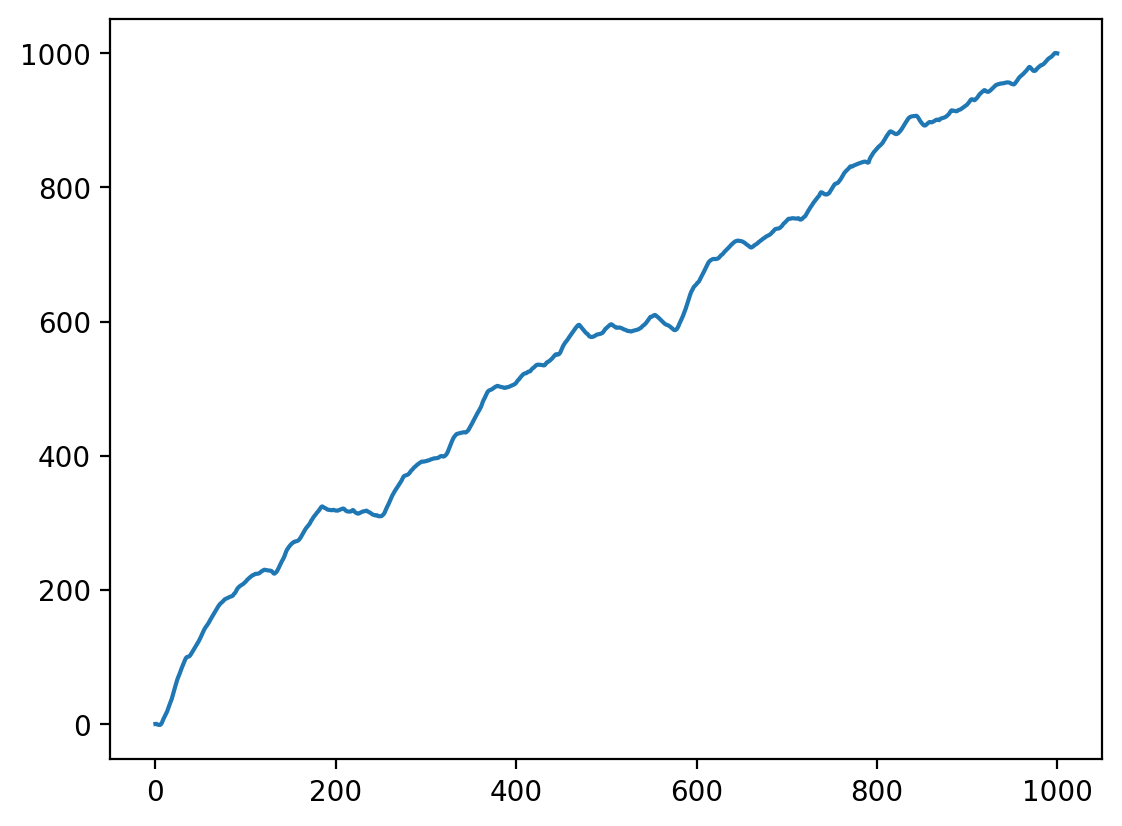

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(np.cumsum(rewards))
plt.show()


In [24]:
len(qs[0])

74

In [40]:
def plot_kinematics(qs, up_to, idx=-1, total_len=2000):
    fig = plt.figure(figsize=(5, 5))
    if idx == -1:
        qs = [r.q for r in rollout[:up_to]]
        for _idx in range(len(qs[0])):
            plt.scatter(up_to, qs[up_to-1][_idx], c="r")
    else:
        # qs = [r.subtree_com[1][idx] for r in rollout[:up_to]]
        qs = [r.q[idx] for r in rollout[:up_to]]
        plt.scatter(up_to, qs[up_to-1], c="r")
        
    _ = plt.plot(qs, alpha=0.8)
    plt.xlim(0, total_len)
    plt.ylim(-0.15, 0.15)
    plt.axvline(x=up_to, c="r")
    
    plt.title(f"r.q[{idx}] Trajectory")
    fig.canvas.draw()
    graph = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
    graph = cv2.resize(graph, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
    return graph


def stack_vids(vids, qs, up_to=500, target_idx=2):
    concat_vids = []
    for idx, frame in tqdm(enumerate(vids[:up_to])):
        plot = plot_kinematics(qs, idx+1, idx=target_idx, total_len=up_to)
        total = np.hstack((frame, plot))
        concat_vids.append(total)
    return concat_vids

In [41]:
import matplotlib
matplotlib.use('svg') 

In [42]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.

videos = stack_vids(vids, qs, target_idx=2)

500it [01:04,  7.74it/s]


In [43]:
media.show_video(videos, fps=30)

In [29]:
graph.shape

NameError: name 'graph' is not defined

In [ ]:
which = 2
front = 200
qs = [r.q[which] for r in rollout[:front]]
_ = plt.plot(qs, alpha=0.8)
plt.xlim(0, 2000)
plt.axvline(x=front, c="r")
plt.scatter(front, qs[front-1], c="r")
plt.title(f"r.q[{which}] Trajectory")